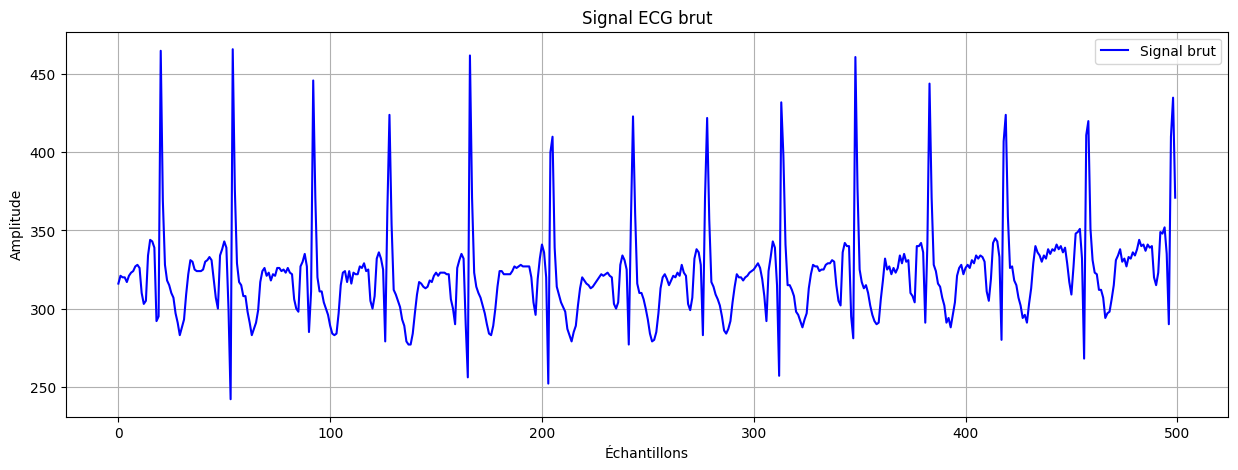

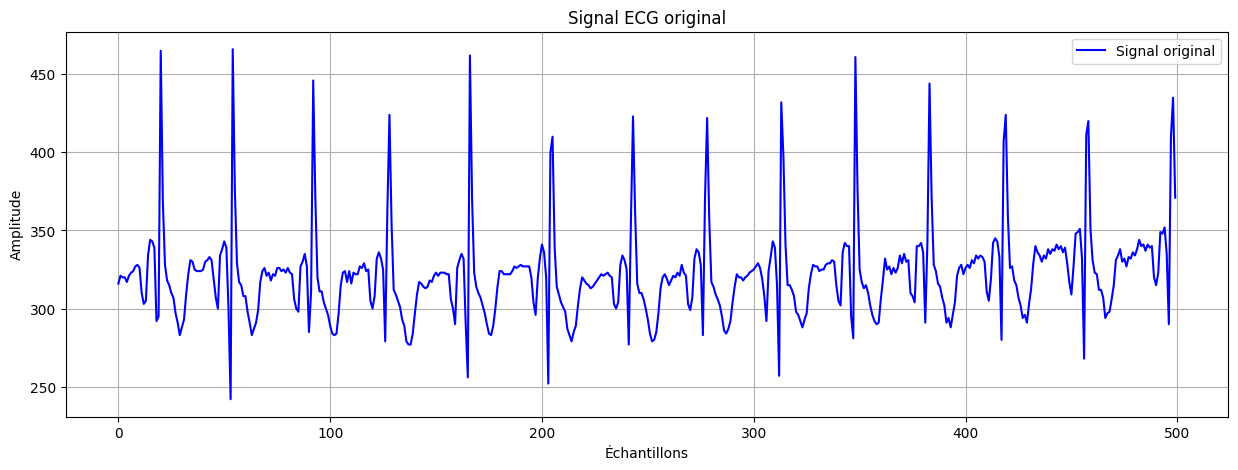

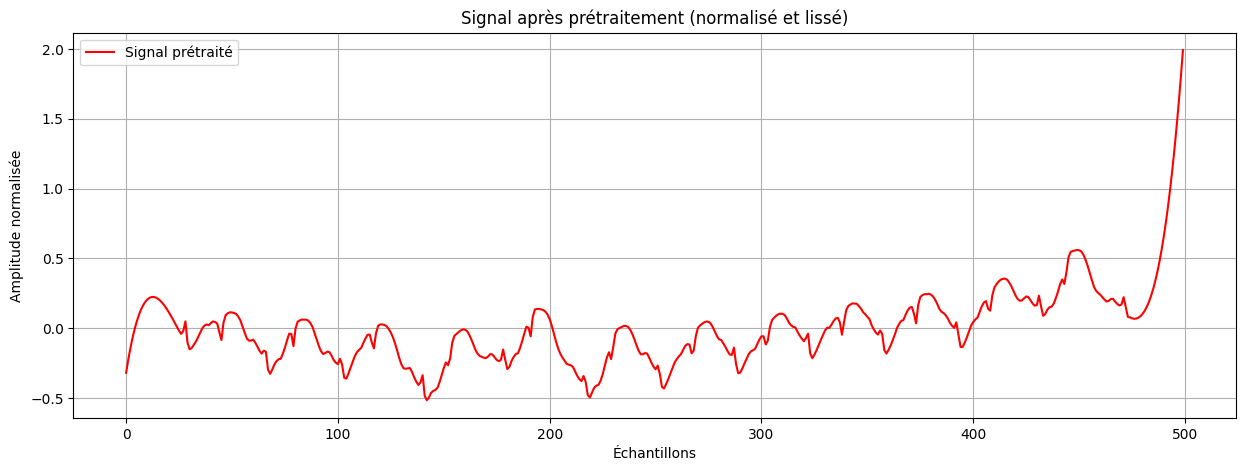

Période détectée : 0.317 secondes
Fréquence cardiaque estimée : 189.5 BPM


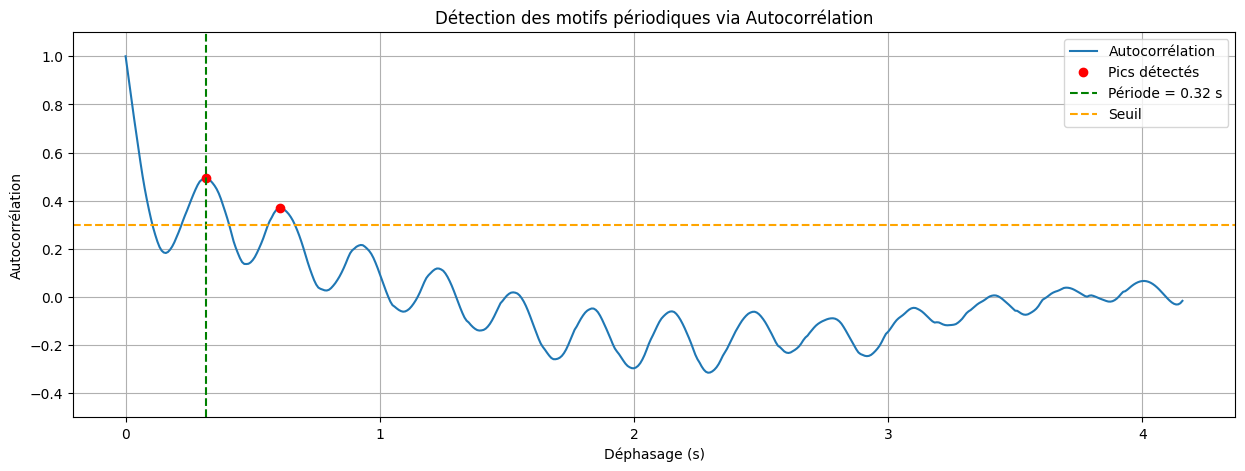

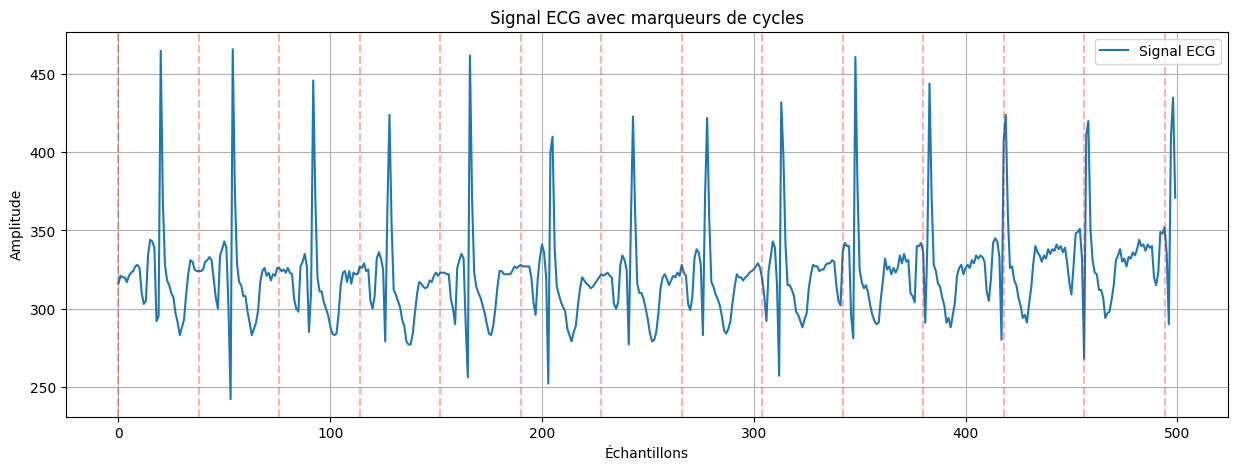

Nombre de pics R détectés : 14


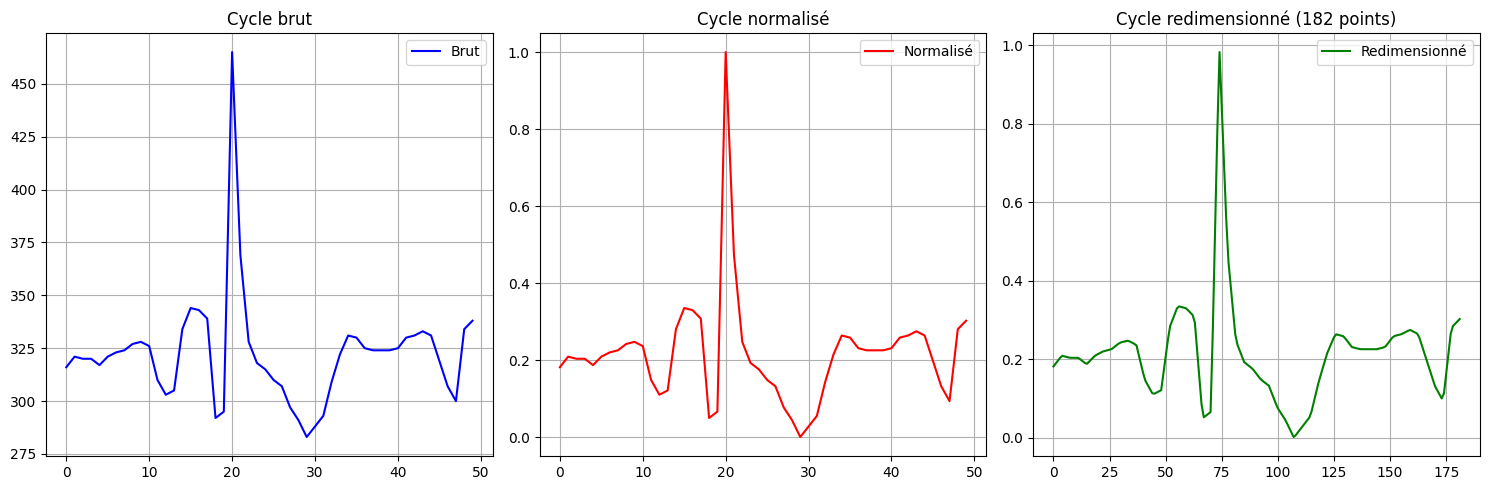

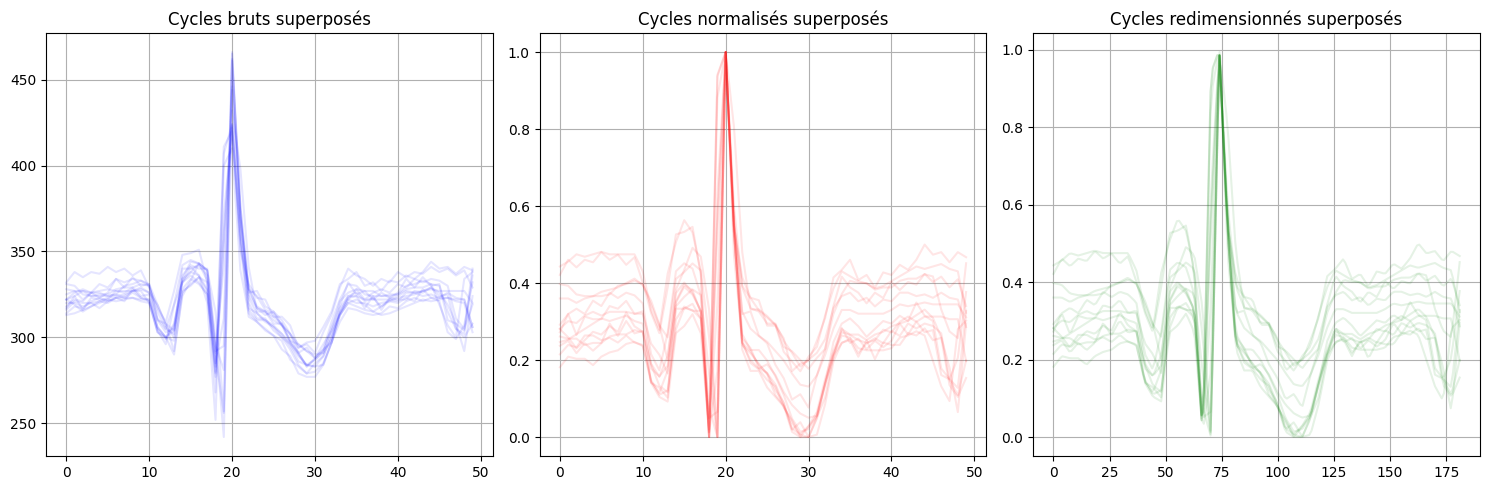

Nombre de cycles extraits : 13


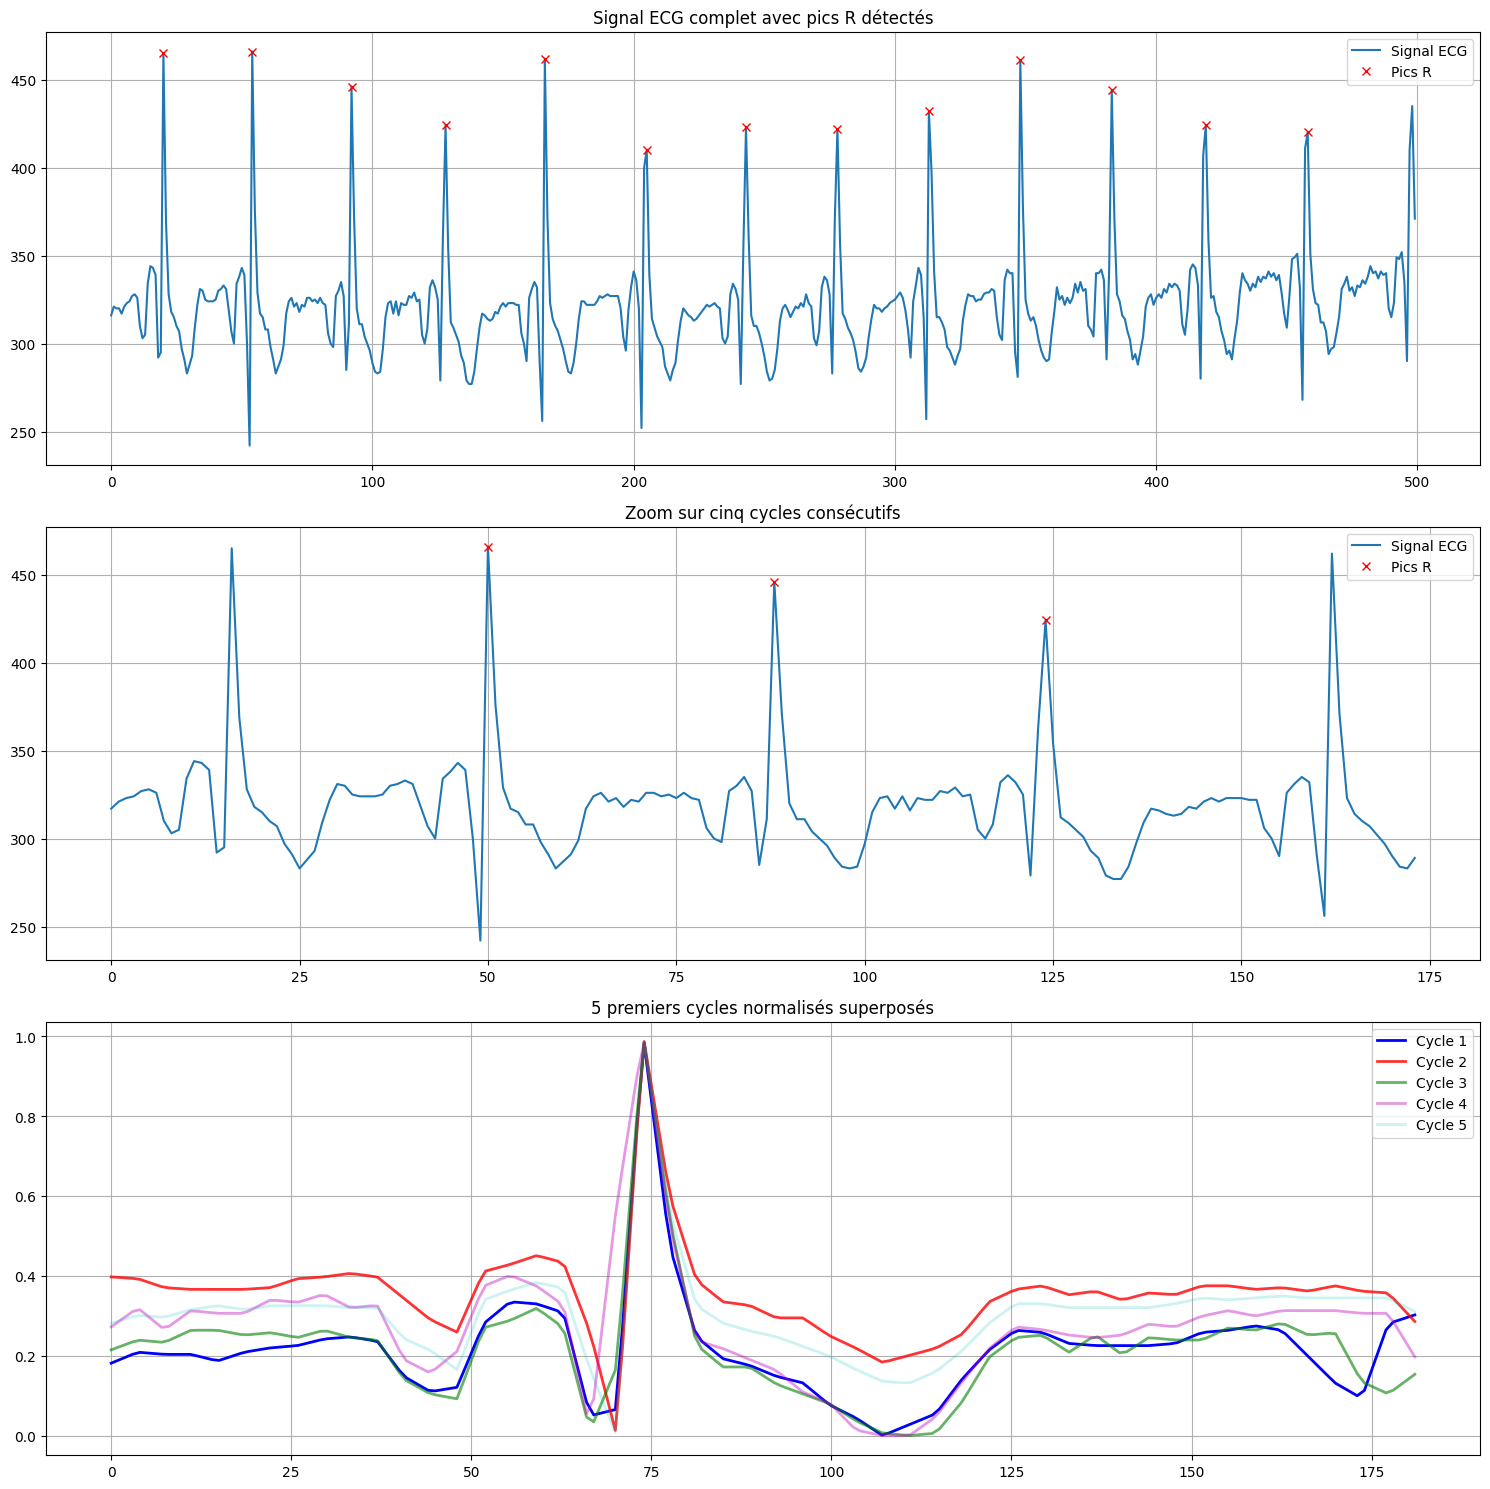

Cycles sauvegardés dans ecg_cycles_20250118_124339.csv


In [7]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks, savgol_filter
import matplotlib.pyplot as plt
from datetime import datetime

class ECGProcessor:
    def __init__(self, sample_rate=120):
        """
        Initialise le processeur ECG
        sample_rate: fréquence d'échantillonnage en Hz
        """
        self.sample_rate = sample_rate
        
    def load_data(self, filename):
        """Charge les données du CSV Arduino et visualise le signal brut"""
        df = pd.read_csv(filename)
        signal = df['ECG_Value'].values
        
        # Visualisation du signal brut
        plt.figure(figsize=(15, 5))
        plt.plot(signal, 'b-', label='Signal brut')
        plt.title('Signal ECG brut')
        plt.xlabel('Échantillons')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.show()
        
        return signal
    
    def analyze_cycle_distance(self, signal, visualize=True):
        """
        Analyse la distance entre les cycles avec autocorrélation et visualise le prétraitement
        """
        # Visualisation du signal original
        plt.figure(figsize=(15, 5))
        plt.plot(signal, 'b-', label='Signal original')
        plt.title('Signal ECG original')
        plt.xlabel('Échantillons')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.show()

        # Prétraitement du signal
        processed_signal = (signal - np.mean(signal)) / np.std(signal)
        processed_signal = savgol_filter(processed_signal, window_length=51, polyorder=3)
        processed_signal = processed_signal - np.mean(processed_signal)
        
        # Visualisation du prétraitement
        plt.figure(figsize=(15, 5))
        plt.plot(processed_signal, 'r-', label='Signal prétraité')
        plt.title('Signal après prétraitement (normalisé et lissé)')
        plt.xlabel('Échantillons')
        plt.ylabel('Amplitude normalisée')
        plt.grid(True)
        plt.legend()
        plt.show()
        
        # Calcul de l'autocorrélation
        autocorr = np.correlate(processed_signal, processed_signal, mode='full')
        autocorr = autocorr[len(autocorr)//2:]  # Garder seulement les lags positifs
        
        # Normaliser l'autocorrélation
        autocorr = autocorr / autocorr[0]
        
        # Création de l'axe temporel
        time_axis = np.arange(len(autocorr)) / self.sample_rate
        
        # Trouver les pics significatifs
        min_samples = int(0.2 * self.sample_rate)  # Minimum 0.2s entre pics
        peaks, properties = find_peaks(autocorr[min_samples:],
                                     height=0.3,
                                     distance=min_samples,
                                     prominence=0.2)
        peaks = peaks + min_samples
        
        if len(peaks) > 0:
            cycle_length = peaks[0]
            period = cycle_length / self.sample_rate
            print(f"Période détectée : {period:.3f} secondes")
            print(f"Fréquence cardiaque estimée : {60/period:.1f} BPM")
            
            if visualize:
                plt.figure(figsize=(15, 5))
                plt.plot(time_axis, autocorr, label='Autocorrélation')
                plt.plot(time_axis[peaks], autocorr[peaks], "ro", label='Pics détectés')
                plt.axvline(x=period, color='g', linestyle='--',
                          label=f'Période = {period:.2f} s')
                plt.axhline(y=0.3, color='orange', linestyle='--', label='Seuil')
                plt.xlabel('Déphasage (s)')
                plt.ylabel('Autocorrélation')
                plt.title('Détection des motifs périodiques via Autocorrélation')
                plt.grid(True)
                plt.legend()
                plt.ylim(-0.5, 1.1)
                plt.show()
            
            return cycle_length
        return None

    def verify_cycle_distance(self, signal, cycle_length):
        """
        Visualise le signal avec des lignes verticales à chaque cycle supposé
        """
        plt.figure(figsize=(15, 5))
        plt.plot(signal, label='Signal ECG')
        
        # Tracer des lignes verticales aux multiples de cycle_length
        for i in range(0, len(signal), cycle_length):
            plt.axvline(x=i, color='r', alpha=0.3, linestyle='--')
        
        plt.title('Signal ECG avec marqueurs de cycles')
        plt.xlabel('Échantillons')
        plt.ylabel('Amplitude')
        plt.grid(True)
        plt.legend()
        plt.show()

    def find_r_peaks(self, signal, cycle_length=None):
        """
        Trouve les pics R dans le signal
        """
        if cycle_length is None:
            min_distance = 30  # Valeur par défaut
        else:
            min_distance = int(0.8 * cycle_length)  # 80% de la période
            
        peaks, _ = find_peaks(signal,
                            height=350,  # Seuil minimal pour un pic R
                            distance=min_distance,
                            prominence=50)  # Proéminence minimale
        return peaks

    def extract_cycles(self, signal, r_peaks, before_r=20, after_r=30, target_length=182):
        """
        Extrait, normalise et redimensionne les cycles avec visualisation
        """
        cycles_raw = []      # Cycles bruts
        cycles_norm = []     # Cycles normalisés
        cycles_resampled = [] # Cycles redimensionnés
        valid_peaks = []
        
        for peak in r_peaks:
            if peak - before_r >= 0 and peak + after_r < len(signal):
                # Extraction du cycle brut
                cycle_raw = signal[peak - before_r:peak + after_r]
                cycles_raw.append(cycle_raw)
                
                # Normalisation min-max
                cycle_min = np.min(cycle_raw)
                cycle_max = np.max(cycle_raw)
                cycle_norm = (cycle_raw - cycle_min) / (cycle_max - cycle_min)
                cycles_norm.append(cycle_norm)
                
                # Redimensionnement
                x_original = np.arange(len(cycle_norm))
                x_new = np.linspace(0, len(cycle_norm)-1, target_length)
                cycle_resampled = np.interp(x_new, x_original, cycle_norm)
                
                cycles_resampled.append(cycle_resampled)
                valid_peaks.append(peak)
        
        if len(cycles_resampled) > 0:
            # Visualisation des étapes pour le premier cycle
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            plt.plot(cycles_raw[0], 'b-', label='Brut')
            plt.title('Cycle brut')
            plt.grid(True)
            plt.legend()
            
            plt.subplot(1, 3, 2)
            plt.plot(cycles_norm[0], 'r-', label='Normalisé')
            plt.title('Cycle normalisé')
            plt.grid(True)
            plt.legend()
            
            plt.subplot(1, 3, 3)
            plt.plot(cycles_resampled[0], 'g-', label='Redimensionné')
            plt.title(f'Cycle redimensionné ({target_length} points)')
            plt.grid(True)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
            
            # Superposition de tous les cycles après chaque étape
            plt.figure(figsize=(15, 5))
            
            plt.subplot(1, 3, 1)
            for cycle in cycles_raw:
                plt.plot(cycle, alpha=0.1, color='blue')
            plt.title('Cycles bruts superposés')
            plt.grid(True)
            
            plt.subplot(1, 3, 2)
            for cycle in cycles_norm:
                plt.plot(cycle, alpha=0.1, color='red')
            plt.title('Cycles normalisés superposés')
            plt.grid(True)
            
            plt.subplot(1, 3, 3)
            for cycle in cycles_resampled:
                plt.plot(cycle, alpha=0.1, color='green')
            plt.title('Cycles redimensionnés superposés')
            plt.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        return np.array(cycles_resampled), np.array(valid_peaks)
    
    def plot_detection(self, signal, r_peaks, cycles=None):
        """
        Visualise la détection des pics et les cycles avec plusieurs vues
        """
        plt.figure(figsize=(15, 15))
        
        # Signal complet avec pics R
        plt.subplot(3, 1, 1)
        plt.plot(signal, label='Signal ECG')
        plt.plot(r_peaks, signal[r_peaks], "rx", label='Pics R')
        plt.title('Signal ECG complet avec pics R détectés')
        plt.legend()
        plt.grid(True)
        
        # Zoom sur une section
        if len(r_peaks) > 3:
            start_idx = r_peaks[1] - 50
            end_idx = r_peaks[3] + 50
            plt.subplot(3, 1, 2)
            plt.plot(signal[start_idx:end_idx], label='Signal ECG')
            plt.plot(r_peaks[1:4] - start_idx, signal[r_peaks[1:4]], "rx", label='Pics R')
            plt.title('Zoom sur cinq cycles consécutifs')
            plt.legend()
            plt.grid(True)
        
        # Cycles superposés
        if cycles is not None and len(cycles) > 0:
            plt.subplot(3, 1, 3)
            colors = ['b', 'r', 'g', 'm', 'c']
            alphas = [1.0, 0.8, 0.6, 0.4, 0.2]
            for i, cycle in enumerate(cycles[:5]):
                plt.plot(cycle, 
                        color=colors[i % len(colors)], 
                        alpha=alphas[i % len(alphas)],
                        linewidth=2,
                        label=f'Cycle {i+1}')
            plt.title('5 premiers cycles normalisés superposés')
            plt.legend()
            plt.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def save_cycles(self, cycles, filename=None):
        """Sauvegarde les cycles dans un CSV"""
        if filename is None:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            filename = f"ecg_cycles_{timestamp}.csv"
            
        np.savetxt(filename, cycles, delimiter=',')
        print(f"Cycles sauvegardés dans {filename}")
        return filename

def main():
    # Initialisation
    processor = ECGProcessor(sample_rate=120)
    
    # Chargement des données
    signal = processor.load_data('arduino_brut_data.csv')
    
    # Analyse de la distance entre cycles
    cycle_length = processor.analyze_cycle_distance(signal)
    if cycle_length is None:
        print("Impossible de déterminer la période des cycles")
        return
        
    # Vérification visuelle de la période
    processor.verify_cycle_distance(signal, cycle_length)
    
    # Détection des pics R
    r_peaks = processor.find_r_peaks(signal, cycle_length)
    print(f"Nombre de pics R détectés : {len(r_peaks)}")
    
    # Extraction et visualisation des cycles
    cycles, valid_peaks = processor.extract_cycles(signal, r_peaks)
    print(f"Nombre de cycles extraits : {len(cycles)}")
    
    # Visualisations finales
    processor.plot_detection(signal, valid_peaks, cycles)
    
    # Sauvegarde
    if len(cycles) > 0:
        processor.save_cycles(cycles)

if __name__ == "__main__":
    main()